In [1]:
# PART 1: Spark aggregation to state-year (weighted rates/means)
from pyspark.sql import SparkSession, functions as F
from pathlib import Path

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("MicroAggregateForSklearn").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),

    # Demographics
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('SEX') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SEX_female_share'),
    (F.sum(F.when(F.col('MAR').isin(1, 2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MAR_ever_married_share'),

    # Health insurance coverage
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS2') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS2_direct_share'),
    (F.sum(F.when(F.col('HINS3') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS3_medicare_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.when(F.col('HINS5') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS5_tricare_share'),
    (F.sum(F.when(F.col('HINS6') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS6_va_share'),

    # Economic & income
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_lt138_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.col('WAGP') * F.col(weight_col)) / wt_sum).alias('WAGP_mean'),
    (F.sum(F.col('SEMP') * F.col(weight_col)) / F.sum(F.when(F.col('SEMP') > 0, F.col(weight_col)).otherwise(None))).alias('SEMP_mean_if_positive'),
    (F.sum(F.col('SSP') * F.col(weight_col)) / wt_sum).alias('SSP_per_capita'),
    (F.sum(F.when(F.col('RETP') > 0, F.col(weight_col)).otherwise(0)) / wt_sum).alias('RETP_positive_share'),

    # Employment & labor
    (F.sum(F.when(F.col('ESR').isin(3, 6), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_unemp_or_nilf_share'),
    (F.sum(F.when(F.col('ESR').isin(1, 2, 3, 4, 5), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_in_labor_force_share'),

    # Education & social
    (F.sum(F.when(F.col('SCHL') >= 21, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SCHL_bach_plus_share'),
    (F.sum(F.when(F.col('DOUT') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DOUT_diff_share'),
    (F.sum(F.when(F.col('DPHY') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DPHY_diff_share'),
    (F.sum(F.when(F.col('DIS') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DIS_any_share'),
    (
        1000.0
        * F.sum(
            F.when(
                (F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)) & (F.col('FER') == 1),
                F.col(weight_col),
            ).otherwise(0)
        )
        / F.sum(F.when((F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)), F.col(weight_col)).otherwise(None))
    ).alias('FER_births_per_1000_women_15_50'),

    # Access & lifestyle
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean_per_person'),
    (F.sum(F.when(F.col('MIL').isin(2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_veteran_share'),
    (F.sum(F.when(F.col('MIL') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_active_duty_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 09:27:03 WARN Utils: Your hostname, compilings-Mac-mini.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.237 instead (on interface en0)
25/12/02 09:27:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 09:27:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/02 09:27:06 WARN FileStreamSink: Assume no metadata directory. Error while looking for metadata directory in the path: /Users/compiling/435Project/Project/complete/pums_*.parquet.
java.io.FileNotFoundException: File /Users/compiling/435Project/Project/complete/pums_*.parquet does not exist
	at org.apache.had

Total micro rows (all years): 15912393
Aggregating microdata to state-year panel ...


25/12/02 09:27:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Final panel shape: (255, 32)


,STATE_NAME,YEAR,state_year_population,TOTAL_HEALTH_SPENDING,AGEP_65plus_share,AGEP_0_17_share,SEX_female_share,MAR_ever_married_share,HICOV_uninsured_share,HINS1_employer_share,...,ESR_in_labor_force_share,SCHL_bach_plus_share,DOUT_diff_share,DPHY_diff_share,DIS_any_share,FER_births_per_1000_women_15_50,BROADBND_yes_share,VEH_mean_per_person,MIL_veteran_share,MIL_active_duty_share
0,Georgia,2023,11029227,7984.0,0.153987,0.229787,0.512272,0.510425,0.118536,0.522321,...,0.513037,0.249936,0.048654,0.066701,0.138376,50.980524,0.882308,2.146883,0.063762,0.005160
1,New Jersey,2023,9290841,9676.0,0.177698,0.216073,0.507687,0.521444,0.071422,0.598993,...,0.541512,0.326099,0.045048,0.054495,0.112192,51.128098,0.902386,1.919621,0.034651,0.000931
2,Minnesota,2021,5707390,8686.0,0.168798,0.228722,0.499954,0.533945,0.043775,0.609255,...,0.547687,0.277308,0.047489,0.050248,0.124941,56.288797,0.875737,2.168501,0.059511,0.000425
3,Kansas,2023,2940547,8502.0,0.176232,0.233088,0.497563,0.549769,0.083518,0.573489,...,0.526105,0.253048,0.050902,0.065071,0.146462,55.325867,0.865346,2.234180,0.061661,0.008434
4,Utah,2021,3337975,5734.0,0.116340,0.282819,0.492425,0.517114,0.093118,0.633758,...,0.516075,0.227447,0.034616,0.040597,0.106772,59.919620,0.897629,2.513679,0.044944,0.002226


In [2]:
# PART 2: Pooled RF model (per-capita target, shuffled split)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
drop_from_X = {
    target, 'STATE_NAME', 'ST', 'state_year_population',
    'SSP_per_capita', 'RETP_positive_share',
    'DOUT_diff_share', 'DPHY_diff_share',
}
numeric_cols = [c for c in df_state_year.columns if c not in drop_from_X]

X = df_state_year[categorical_cols + numeric_cols]
y = df_state_year[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f'Training on {len(X_train)} samples, Testing on {len(X_test)} samples')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    n_jobs=-1,
    random_state=42,
)

pipe = Pipeline([('pre', preprocess), ('rf', rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test R^2 : {r2:,.3f}')
print(f'Test MAE : {mae:,.2f}')
print(f'Test RMSE: {rmse:,.2f}')


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Training on 204 samples, Testing on 51 samples
Test R^2 : 0.733
Test MAE : 612.74
Test RMSE: 755.42


In [7]:
# PART 2b: Random Forest feature importances

if hasattr(pipe, 'named_steps') and 'rf' in pipe.named_steps:
    import numpy as np
    import pandas as pd

    rf_model = pipe.named_steps['rf']
    importances = rf_model.feature_importances_
    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': importances,
    }).sort_values('importance', ascending=False)
    print('Top 15 feature importances:')
    print(fi.head(15).to_string(index=False))
else:
    print('RandomForestRegressor not found in pipeline; skipping importances')


Top 15 feature importances:
                 feature  importance
   HICOV_uninsured_share    0.189375
              PINCP_mean    0.120270
     VEH_mean_per_person    0.119567
                    YEAR    0.060293
      HINS2_direct_share    0.050506
   SEMP_mean_if_positive    0.049059
          HINS6_va_share    0.041574
        SEX_female_share    0.034009
         AGEP_0_17_share    0.033838
       AGEP_65plus_share    0.032453
    HINS3_medicare_share    0.029749
    HINS4_medicaid_share    0.028890
 ESR_unemp_or_nilf_share    0.024542
ESR_in_labor_force_share    0.021010
   MIL_active_duty_share    0.019115


In [9]:
# PART 2c: Top 5 feature importances per year (separate RF per year)
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

years = sorted(df_state_year['YEAR'].unique())
print('Per-year RF importances (top 5):')

for yr in years:
    df_y = df_state_year[df_state_year['YEAR'] == yr].copy()
    if df_y.shape[0] < 10:
        print(f'Year {yr}: skipped (too few rows: {df_y.shape[0]})')
        continue

    X_y = df_y[numeric_cols]
    y_y = df_y[target]

    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)

    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': rf_y.feature_importances_,
    }).sort_values('importance', ascending=False).head(5)
    print(f'Year {yr} (rows={len(df_y)}):')
    print(fi.to_string(index=False))
 


Per-year RF importances (top 5):
Year 2019 (rows=51):
                 feature  importance
   HICOV_uninsured_share    0.210674
ESR_in_labor_force_share    0.112111
     VEH_mean_per_person    0.074775
              PINCP_mean    0.067612
         AGEP_0_17_share    0.064631
Year 2020 (rows=51):
                 feature  importance
ESR_in_labor_force_share    0.164571
   HICOV_uninsured_share    0.132387
     VEH_mean_per_person    0.086119
         AGEP_0_17_share    0.075815
              PINCP_mean    0.056550
Year 2021 (rows=51):
              feature  importance
HICOV_uninsured_share    0.193307
           PINCP_mean    0.146944
  VEH_mean_per_person    0.103873
     SEX_female_share    0.058213
 HINS3_medicare_share    0.055018
Year 2022 (rows=51):
               feature  importance
 HICOV_uninsured_share    0.219292
 SEMP_mean_if_positive    0.137199
   VEH_mean_per_person    0.087491
     AGEP_65plus_share    0.051615
MAR_ever_married_share    0.044848
Year 2023 (rows=51):
    

In [3]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [129]:
# scikit-optimize install (run manually if needed):
# %pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scikit-optimize]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# XGBoost baseline model


xgb_available = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    print('XGBoost not available:', e)
    xgb_available = False

if xgboost_available := xgb_available:
    X = df_state_year[numeric_cols]
    y = df_state_year[target]
    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        objective='reg:squarederror',
    )

    xgb.fit(X_train_x, y_train_x)

    for name, yt, yp in [('Train', y_train_x, xgb.predict(X_train_x)), ('Test', y_test_x, xgb.predict(X_test_x))]:
        rmse = root_mean_squared_error(yt, yp)
        mae = mean_absolute_error(yt, yp)
        r2 = r2_score(yt, yp)
        print(f"{name} -> RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R^2: {r2:.3f}")

    xgb_baseline_model = xgb
    y_pred_xgb = xgb.predict(X_test_x)
else:
    print('Skipping XGBoost baseline; xgboost not available in this environment')


Train -> RMSE: 0.12  MAE: 0.09  R^2: 1.000
Test -> RMSE: 634.48  MAE: 499.36  R^2: 0.812


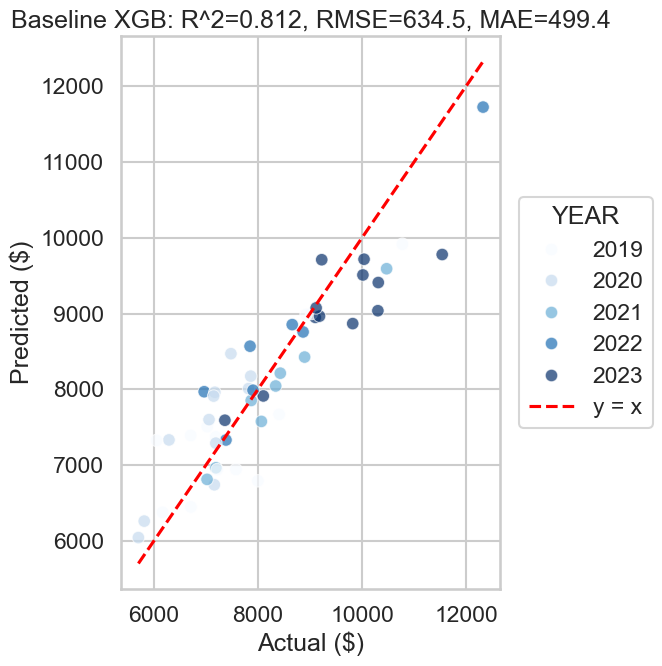

In [5]:
sns.set_theme(style="whitegrid", context="talk")

if 'xgb_baseline_model' in globals() and xgb_available:
    rmse = root_mean_squared_error(y_test_x, y_pred_xgb)
    mae = mean_absolute_error(y_test_x, y_pred_xgb)
    r2 = r2_score(y_test_x, y_pred_xgb)
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test_x, y=y_pred_xgb,
                    hue=X_test_x['YEAR'] if 'YEAR' in X_test_x else None,
                    palette='Blues', alpha=0.7)
    lo, hi = min(y_test_x.min(), y_pred_xgb.min()), max(y_test_x.max(), y_pred_xgb.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline XGB: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()
else:
    print('XGB baseline not available in this environment')


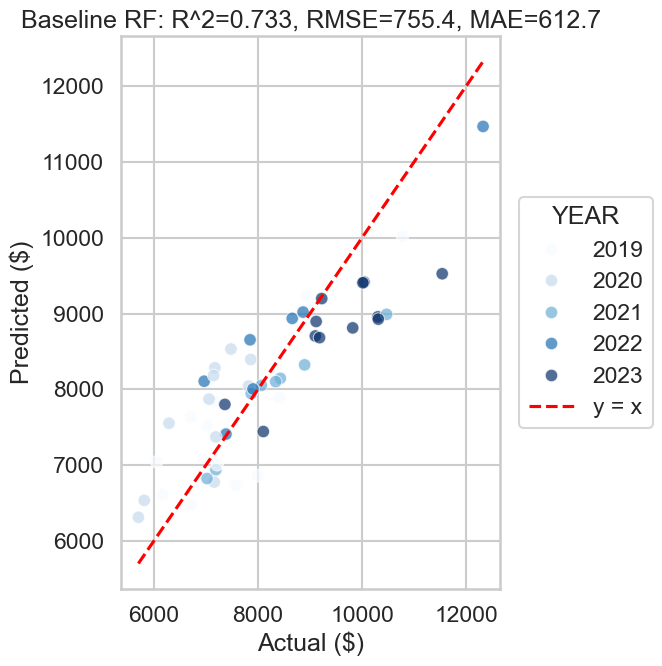

In [6]:
sns.set_theme(style="whitegrid", context="talk")

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred,
                hue=X_test['YEAR'] if 'YEAR' in X_test else None,
                palette='Blues', alpha=0.7)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
plt.xlabel('Actual ($)')
plt.ylabel('Predicted ($)')
plt.title(f'Baseline RF: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
plt.tight_layout()
plt.show()
